# Importing Dependencies

In [1]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Importing Evaluation Metrices 

In [3]:
from tensorflow.keras.metrics import Precision, Recall, SpecificityAtSensitivity

pre = Precision()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

# Creating CNN Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', pre, rec, spe])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

In [5]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

# Loading Dataset

In [6]:
train_dir = 'imgdata_v2/split_dataset/train/'
val_dir = 'imgdata_v2/split_dataset/val/'
test_dir = 'imgdata_v2/split_dataset/test/'

# Data Augmentation 

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_data = ImageDataGenerator(rescale=1./255)
    
train_generator = train_data.flow_from_directory(train_dir,
                                                   batch_size=16, 
                                                   target_size=(256,256),
                                                   class_mode='binary')

Found 1456 images belonging to 2 classes.


In [9]:
val_data = ImageDataGenerator(rescale=1./255)

val_generator = val_data.flow_from_directory(val_dir,
                                                batch_size=16,
                                                target_size=(256, 256),
                                                class_mode='binary')

Found 415 images belonging to 2 classes.


# Training Non-Augmented Model

In [11]:
model_fit = model.fit(train_generator, 
                      epochs=10, 
                      shuffle=True, 
                      validation_data=val_generator, 
                      callbacks=[tfb_callback])

Epoch 1/10
91/91 [==============================] - 10s 106ms/step - loss: 0.2993 - accuracy: 0.8716 - precision: 0.8568 - recall: 0.9013 - specificity_at_sensitivity: 0.9887 - val_loss: 0.3177 - val_accuracy: 0.9012 - val_precision: 0.8589 - val_recall: 0.9673 - val_specificity_at_sensitivity: 1.0000
Epoch 2/10
91/91 [==============================] - 9s 103ms/step - loss: 0.2552 - accuracy: 0.8908 - precision: 0.8755 - recall: 0.9187 - specificity_at_sensitivity: 0.9915 - val_loss: 0.2513 - val_accuracy: 0.9060 - val_precision: 0.8889 - val_recall: 0.9346 - val_specificity_at_sensitivity: 1.0000
Epoch 3/10
91/91 [==============================] - 10s 109ms/step - loss: 0.2362 - accuracy: 0.9004 - precision: 0.8883 - recall: 0.9227 - specificity_at_sensitivity: 0.9943 - val_loss: 0.2527 - val_accuracy: 0.8988 - val_precision: 0.9257 - val_recall: 0.8738 - val_specificity_at_sensitivity: 1.0000
Epoch 4/10
91/91 [==============================] - 9s 101ms/step - loss: 0.2310 - accuracy:

# Plotting Model Performance

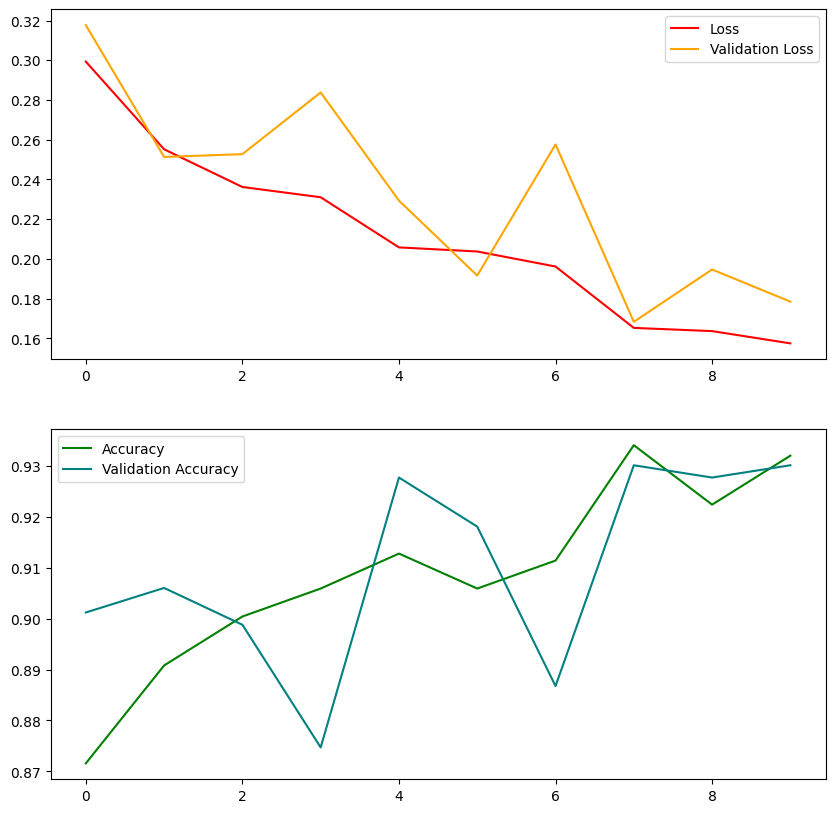

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

# Evaluating Model Performance

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                batch_size=16,
                                                target_size=(256, 256),
                                                class_mode='binary')

Found 210 images belonging to 2 classes.


In [15]:
evaluation = model.evaluate(test_generator, verbose=1)

accuracy = evaluation[1]  # 'accuracy'
precision = evaluation[2]  # Precision
recall = evaluation[3]     # Recall
specificity = evaluation[4]  # SpecificityAtSensitivity(0.5)

f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {round(accuracy, 5)}')
print(f'Precision: {round(precision, 5)}')
print(f'Recall: {round(recall, 5)}')
print(f'Specificity (at sensitivity 0.5): {round(specificity, 5)}')
print(f'F1: {round(f1, 5)}')

14/14 [==============================] - 1s 66ms/step - loss: 0.1496 - accuracy: 0.9381 - precision: 0.9358 - recall: 0.9444 - specificity_at_sensitivity: 1.0000
Accuracy: 0.9381
Precision: 0.93578
Recall: 0.94444
Specificity (at sensitivity 0.5): 1.0
F1: 0.94009


# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             brightness_range=(0.1, 1.5),
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

train_gen = train_datagen.flow_from_directory(train_dir,
                                             batch_size=16, 
                                             target_size = (256, 256), 
                                             class_mode='binary')